In [1]:
import json, sys, random
import numpy as np
import pandas as pd
import tensorflow as tf


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Dropout

from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
import keras.callbacks


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw 

In [4]:
# download dataset from json object
f = open('shipsnet.json')
dataset = json.load(f)
f.close()

In [5]:
# Turning the json information into a numpy array and then assign it as our X and y values

X = np.array(dataset['data']).astype('uint8')
y = np.array(dataset['labels']).astype('uint8')

In [6]:
# Checking the amount of ship and not a ship labels for the images

pd.Series(y).value_counts()

0    3000
1    1000
dtype: int64

In [7]:
X_reshaped = X.reshape([-1, 3, 80, 80])

X_reshaped.shape

(4000, 3, 80, 80)

In [8]:
# get one chanel
pic = X_reshaped[3]

Red_Channel = pic[0]
Green_Channel = pic[1]
Blue_Channel = pic[2]

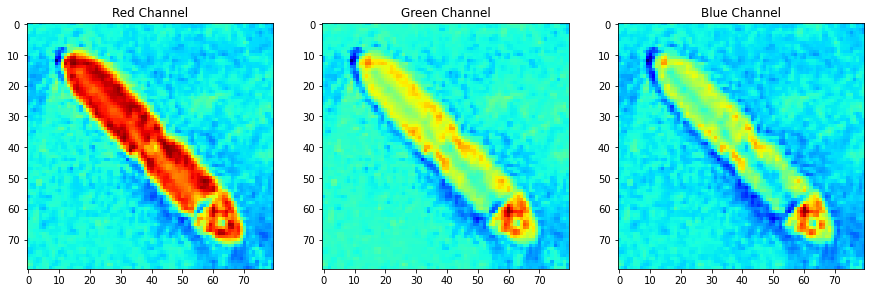

In [9]:
plt.figure(2, figsize = (5*3, 5*1))
plt.set_cmap('jet')

# getting each channel
plt.subplot(1, 3, 1)
plt.imshow(Red_Channel)
plt.title("Red Channel")

plt.subplot(1, 3, 2)
plt.imshow(Green_Channel)
plt.title("Green Channel")

plt.subplot(1, 3, 3)
plt.imshow(Blue_Channel)
plt.title("Blue Channel")
    
plt.show()

In [10]:
# We need to change the order of the dimensions to get the correct format to plot the images 

X_reshaped = X.reshape([-1, 3, 80, 80]).transpose([0,2,3,1])

X_reshaped.shape

(4000, 80, 80, 3)

In [11]:
y_reshaped = tf.keras.utils.to_categorical(y, num_classes=2)

y_reshaped.shape

(4000, 2)

In [12]:
# Separating X_reshaped to correspond with the different labels

imgs_0 = X_reshaped[y==0]
imgs_1 = X_reshaped[y==1]

In [13]:
# Normalizing the X values

X_reshaped = X_reshaped / 255

In [14]:
# Doing the initial train/test split on the reshaped values

X_train_full, X_test, y_train_full, y_test = train_test_split(X_reshaped, y_reshaped, test_size=0.20, random_state=42)

# Creating the validation set

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

In [15]:
np.random.seed(42)


In [16]:
# network design
model = keras.Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(80, 80, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #40x40
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #20x20
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #10x10
model.add(Dropout(0.25))

model.add(Conv2D(32, (10, 10), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #5x5
model.add(Dropout(0.25))

model.add(Flatten())

# fully con
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

In [17]:
# optimization setup
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(
    loss='categorical_crossentropy',
    optimizer=sgd,
    metrics=['accuracy'])

In [18]:
# training
history = model.fit(
    X_train, 
    y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    verbose=2)

Epoch 1/20
75/75 - 102s - loss: 0.4447 - accuracy: 0.8017 - val_loss: 0.2758 - val_accuracy: 0.8863 - 102s/epoch - 1s/step
Epoch 2/20
75/75 - 59s - loss: 0.2545 - accuracy: 0.8888 - val_loss: 0.1925 - val_accuracy: 0.9450 - 59s/epoch - 790ms/step
Epoch 3/20
75/75 - 59s - loss: 0.1850 - accuracy: 0.9258 - val_loss: 0.1554 - val_accuracy: 0.9413 - 59s/epoch - 782ms/step
Epoch 4/20
75/75 - 57s - loss: 0.1534 - accuracy: 0.9379 - val_loss: 0.1418 - val_accuracy: 0.9563 - 57s/epoch - 764ms/step
Epoch 5/20
75/75 - 57s - loss: 0.1369 - accuracy: 0.9429 - val_loss: 0.1176 - val_accuracy: 0.9613 - 57s/epoch - 764ms/step
Epoch 6/20
75/75 - 57s - loss: 0.1185 - accuracy: 0.9550 - val_loss: 0.0944 - val_accuracy: 0.9675 - 57s/epoch - 755ms/step
Epoch 7/20
75/75 - 57s - loss: 0.0994 - accuracy: 0.9617 - val_loss: 0.1093 - val_accuracy: 0.9588 - 57s/epoch - 755ms/step
Epoch 8/20
75/75 - 57s - loss: 0.1151 - accuracy: 0.9542 - val_loss: 0.1058 - val_accuracy: 0.9588 - 57s/epoch - 766ms/step
Epoch 9/2

In [19]:
# Finding our final accuracy on the test set

model.evaluate(X_test, y_test)

25/25 [==============================] - 4s 173ms/step - loss: 0.0917 - accuracy: 0.9825


[0.09168966114521027, 0.9825000166893005]

In [20]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 40, 40, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 32)        0

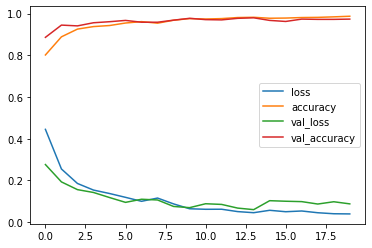

In [21]:
# Plotting the loss and accuracy

pd.DataFrame(history.history).plot();


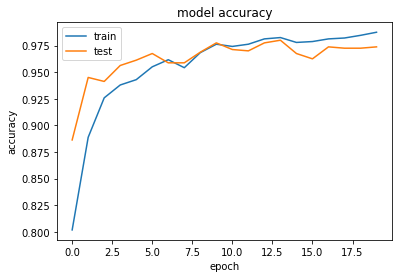

In [22]:
# View model training accuracy graph.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

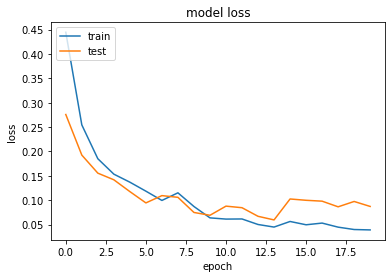

In [23]:
# View model training loss graph.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
y_pred = model.predict(X_test)

25/25 [==============================] - 4s 133ms/step


In [25]:
y_pred = (y_pred > 0.5) 


In [45]:
filename = "model.h5"
model.save(filename)

In [40]:
import pickle

In [44]:
with open('shipnet.pkl','wb')as file:
    pickle.dump(model,file)

In [26]:
from sklearn.metrics import classification_report,accuracy_score

# print("Accuracy: "+str(accuracy_score(y_train, y_pred)))
# print('\n')
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       591
           1       0.97      0.97      0.97       209

   micro avg       0.98      0.98      0.98       800
   macro avg       0.98      0.98      0.98       800
weighted avg       0.98      0.98      0.98       800
 samples avg       0.98      0.98      0.98       800



In [27]:
image = Image.open('sample input.png')
pix = image.load()

In [28]:
n_spectrum = 3
width = image.size[0]
height = image.size[1]

In [29]:
# creat vector
picture_vector = []
for chanel in range(n_spectrum):
    for y in range(height):
        for x in range(width):
            picture_vector.append(pix[x, y][chanel])

In [30]:
picture_vector = np.array(picture_vector).astype('uint8')
picture_tensor = picture_vector.reshape([n_spectrum, height, width]).transpose(1, 2, 0)

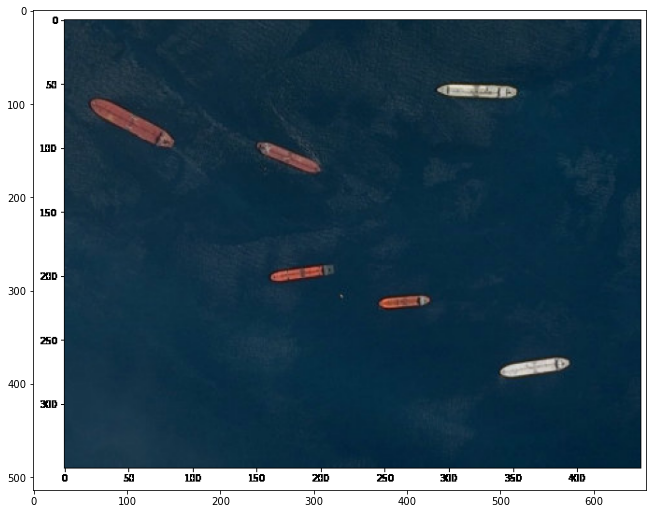

In [31]:
plt.figure(1, figsize = (15, 30))

plt.subplot(3, 1, 1)
plt.imshow(picture_tensor)

plt.show()

In [32]:
picture_tensor = picture_tensor.transpose(2,0,1)
picture_tensor.shape

(3, 514, 657)

In [33]:
def cutting(x, y):
    area_study = np.arange(3*80*80).reshape(3, 80, 80)
    for i in range(80):
        for j in range(80):
            area_study[0][i][j] = picture_tensor[0][y+i][x+j]
            area_study[1][i][j] = picture_tensor[1][y+i][x+j]
            area_study[2][i][j] = picture_tensor[2][y+i][x+j]
    area_study = area_study.reshape([-1, 3, 80, 80])
    area_study = area_study.transpose([0,2,3,1])
    area_study = area_study / 255
    sys.stdout.write('\rX:{0} Y:{1}  '.format(x, y))
    return area_study

In [34]:
def not_near(x, y, s, coordinates):
    result = True
    for e in coordinates:
        if x+s > e[0][0] and x-s < e[0][0] and y+s > e[0][1] and y-s < e[0][1]:
            result = False
    return result

In [35]:
def show_ship(x, y, acc, thickness=3):   
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x-th] = -1

    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x+th+80] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y-th][x+i] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+th+80][x+i] = -1

1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 63ms/step
[[8.2510733e-04 9.9917489e-01]]
0


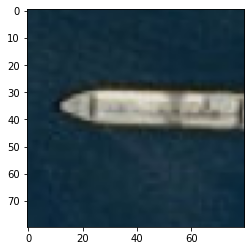

1/1 [==============================] - 0s 48ms/step
[[0.04088028 0.95911974]]
0


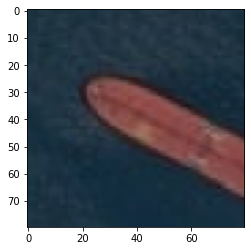

1/1 [==============================] - 0s 33ms/step
[[0.00203248 0.99796754]]
0


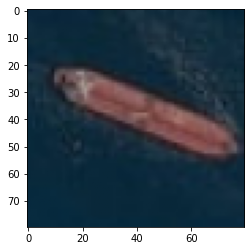

1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 47ms/step
[[1.738853e-05 9.999826e-01]]
0


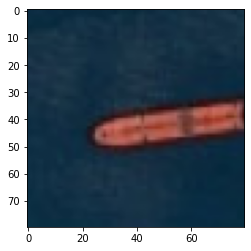

1/1 [==============================] - 0s 62ms/step
[[0.00831062 0.9916893 ]]
0


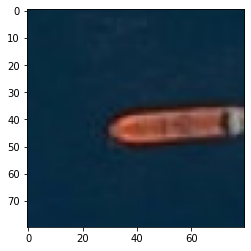

1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step
[[0.07458301 0.925417  ]]
0


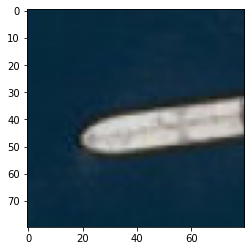

1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 63ms/step


In [36]:
step = 10
coordinates = []
counter=0
for y in range(int((height-(80-step))/step)):
    for x in range(int((width-(80-step))/step) ):
        area = cutting(x*step, y*step)
        
        result = model.predict(area)
        if result[0][1] > 0.90 and not_near(x*step,y*step, 88, coordinates):
            coordinates.append([[x*step, y*step], result])
            print(result)
            print(++counter)
            plt.imshow(area[0])
            plt.show()

In [37]:
for e in coordinates:
    show_ship(e[0][0], e[0][1], e[1][0][1])

In [38]:
#picture_tensor = picture_tensor.transpose(2,0,1)
picture_tensor = picture_tensor.transpose(1,2,0)
picture_tensor.shape

(514, 657, 3)

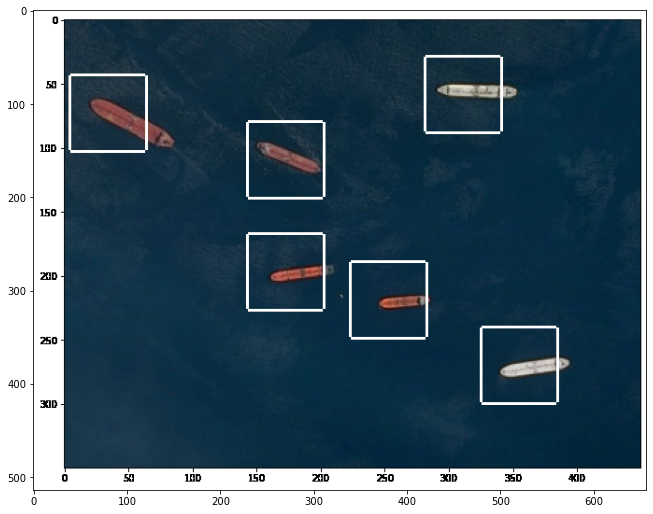

In [39]:
plt.figure(1, figsize = (15, 30))

plt.subplot(3,1,1)
plt.imshow(picture_tensor)
#plt.imsave("pic.png",picture_tensor)
plt.show()